In [1]:
%pip show pytorch-forecasting
# %pip install pytorch-forecasting

Name: pytorch-forecasting
Version: 1.4.0
Summary: Forecasting timeseries with PyTorch - dataloaders, normalizers, metrics and models
Home-page: 
Author: Jan Beitner
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: lightning, numpy, pandas, scikit-learn, scipy, torch
Required-by: 


In [2]:
!nvidia-smi

Sat Jun 21 12:26:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import lightning.pytorch as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch

from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.tuner import Tuner

from pytorch_forecasting.data import TorchNormalizer
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting import RMSE, TimeSeriesDataSet, TemporalFusionTransformer, DeepAR, Baseline, NormalDistributionLoss, QuantileLoss

1. https://github.com/sktime/pytorch-forecasting
2. https://www.cbr.ru/hd_base/ruonia/dynamics/
3. https://www.moex.com/en/index/rtsusdcur.aspx?tid=2601

## Data

In [4]:
!ls

lightning_logs	sample_data  tft.pkl


In [5]:
# ruonia = pd.read_excel("ruonia.xlsx")

In [6]:
# ruonia['date'] = pd.to_datetime(ruonia['DT'], format="%Y-%m-%d")
# ruonia['ruo'] /= 100
# ruonia = ruonia.loc[:, ["date", "ruo"]]

In [7]:
# usdrub = pd.read_csv("Rtsudcur.csv", sep=";")

In [8]:
# usdrub.columns=["date", "usdrub"]
# usdrub['date'] = pd.to_datetime(usdrub['date'], format="%Y-%m-%d")

In [9]:
# full_data = pd.merge(ruonia, usdrub, on="date")
# full_data.set_index("date").plot(subplots=True)

trying monthly

In [10]:
# full_data = (
#     full_data.sort_values("date")
#     .assign(date=lambda df: df.date + pd.tseries.offsets.MonthEnd(1))
#     .drop_duplicates(subset=["date"], keep="last")
# )

In [11]:
# full_data['const'] = 1

In [12]:
# full_data = full_data.reset_index(drop=True)
# full_data = full_data.reset_index(drop=False)

## Model

### Data

In [13]:
full_data = generate_ar_data(n_series=1, timesteps=2500, trend=0, seasonality=4, noise=0.1, level=1)

In [14]:
full_data.head()

,series,time_idx,value
0,0,0,0.000000
1,0,1,0.007177
2,0,2,0.013966
3,0,3,0.021721
4,0,4,0.028431


<Axes: >

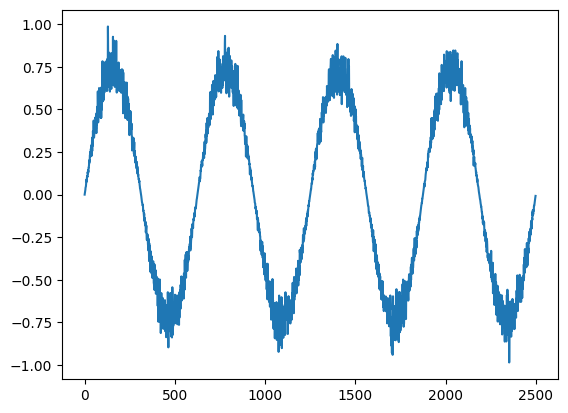

In [15]:
full_data.value.plot()

In [16]:
training = TimeSeriesDataSet(
    full_data[lambda x: x["time_idx"] < 2250],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    min_encoder_length=1000,
    max_encoder_length=2000,
    min_prediction_length=250,
    max_prediction_length=250,
    time_varying_unknown_reals=["value"],
    target_normalizer=TorchNormalizer(
        method='identity', center=True, transformation=None, method_kwargs={}
    ),
    add_target_scales=True
)

In [17]:
train_dataloader = training.to_dataloader(
    train=True, batch_size=256
)

In [18]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    full_data,
    min_prediction_idx=2250,
    stop_randomization=True
)

In [19]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=256
)

### Baseline

In [1]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(
    val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True
)

NameError: name 'Baseline' is not defined

In [ ]:
RMSE()(baseline_predictions.output, baseline_predictions.y)

### Setup

In [ ]:
pl.seed_everything(42)

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min"
)

lr_logger = LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Metric to monitor (same as EarlyStopping)
    save_top_k=1,  # Save only the best model
    mode="min",  # "min" for loss, "max" for accuracy
    save_last=True, # save the last model
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=512,
    min_epochs=20,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.2,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    limit_train_batches=256,
    enable_checkpointing=True,
)

In [ ]:
model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    log_interval=100,
    log_val_interval=10,
    hidden_size=16,
    lstm_layers=2,
    loss=QuantileLoss(quantiles=[0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]),
    optimizer="Adam",
)
print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

In [ ]:
# res = Tuner(trainer).lr_find(
#     model,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     min_lr=1e-10,
#     max_lr=1e1,
#     early_stop_threshold=1000
# )
# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [ ]:
# print(f"suggested learning rate: {res.suggestion()}")

In [ ]:
# trainer = pl.Trainer(
#     max_epochs=512,
#     accelerator="gpu",
#     enable_model_summary=True,
#     gradient_clip_val=0.25,
#     callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
#     # limit_train_batches=256,
#     enable_checkpointing=True,
# )

# model = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.03,
#     log_interval=100,
#     log_val_interval=10,
#     hidden_size=64,
#     # rnn_layers=4,
#     loss=RMSE(), #NormalDistributionLoss(quantiles=[0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]),
#     optimizer="Adam",
# )
# print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

In [ ]:
# del model

In [12]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

NameError: name 'trainer' is not defined

In [ ]:
best_model_path = checkpoint_callback.best_model_path
print(best_model_path)
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [20]:
import pickle

In [ ]:
with open("tft.pkl",'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
del trainer, model, best_model

In [21]:
with open("tft.pkl",'rb') as f:
    model = pickle.load(f)

In [22]:
predictions = model.predict(
    val_dataloader,
    mode="raw",
    # trainer_kwargs=dict(accelerator="gpu"),
    return_y=True
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-

In [45]:
true_vals = predictions.y[0][0,:].cpu()

In [40]:
quantiles = predictions.output.prediction.mean(axis=0).cpu()

In [18]:
del predictions

In [48]:
quantiles.shape

torch.Size([250, 7])

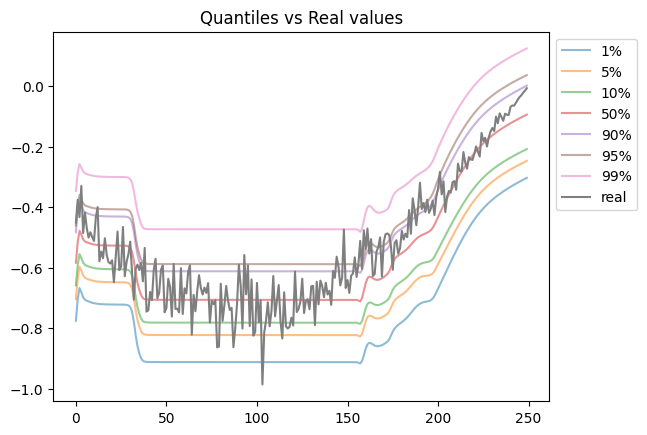

In [55]:
for i, name in enumerate([0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]):
  plt.plot(quantiles[:, i], label=f"{name*100:.0f}%", alpha=0.5)

plt.plot(true_vals, label="real")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Quantiles vs Real values")
plt.show()